In [1]:
import torch
import umap
import numpy as np
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin
from sklearn.preprocessing import LabelEncoder

from src.dataset.audio_dataset import AudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper

from src.models.mel_spectrogram_vae import MelSpectrogramVAE
from src.utils import audio_to_mel_spectrogram

import seaborn as sns
sns.set(style='white', context='poster')

In [2]:
DAFX_TO_USE = ['mda Delay', 'mda Overdrive', 'mda RingMod', 'mda MultiBand']

In [3]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 5_000
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_melspec_vae/eu2tcrkn/checkpoints/epoch=237-step=74494.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def dafx_from_name(dafx_name):
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [5]:
def get_dataset(dafx):
    dataset = AudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES,
        augmentations={},
        length=130_560,
        effect_audio=True,
        dummy_setting=True
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [6]:
latent_embeddings = dict()

In [7]:
model = MelSpectrogramVAE.load_from_checkpoint(CHECKPOINT).to(DEVICE)
model.eval()

MelSpectrogramVAE(
  (encoder): Encoder(
    (_conv_1): Conv2d(1, 4, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
    (_conv_2): Conv2d(4, 8, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
    (_conv_3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (2): Resi

In [8]:
from tqdm import tqdm

embeddings = []

for fx in DAFX_TO_USE:
    dafx = dafx_from_name(fx)
    dataset = get_dataset(dafx)

    for x in tqdm(dataset):
        X = audio_to_mel_spectrogram(signal=x,
                                     sample_rate=model.hparams.sample_rate,
                                     n_mels=model.hparams.n_mels,
                                     n_fft=model.hparams.n_fft,
                                     win_length=model.hparams.win_length,
                                     f_max=model.hparams.f_max,
                                     f_min=model.hparams.f_min).to(DEVICE)



        _, _, _, z = model(X)

        embeddings.append(z.cpu().detach().numpy())

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 38047.50it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 48047.22it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 27229.71it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 41355.60it/s]



Loaded 88 files for train = 66.89 hours.


100%|██████████| 5000/5000 [00:42<00:00, 116.99it/s]


In [9]:
data = np.array(embeddings).squeeze()

In [10]:
data.shape

(20000, 128)

In [11]:
umap_data = umap.UMAP().fit_transform(data)
umap_labels = np.concatenate([[fx]*NUM_EXAMPLES for fx in DAFX_TO_USE]).squeeze()

In [12]:
plot_labels = LabelEncoder().fit_transform(umap_labels)

In [13]:
num_fx = len(DAFX_TO_USE)

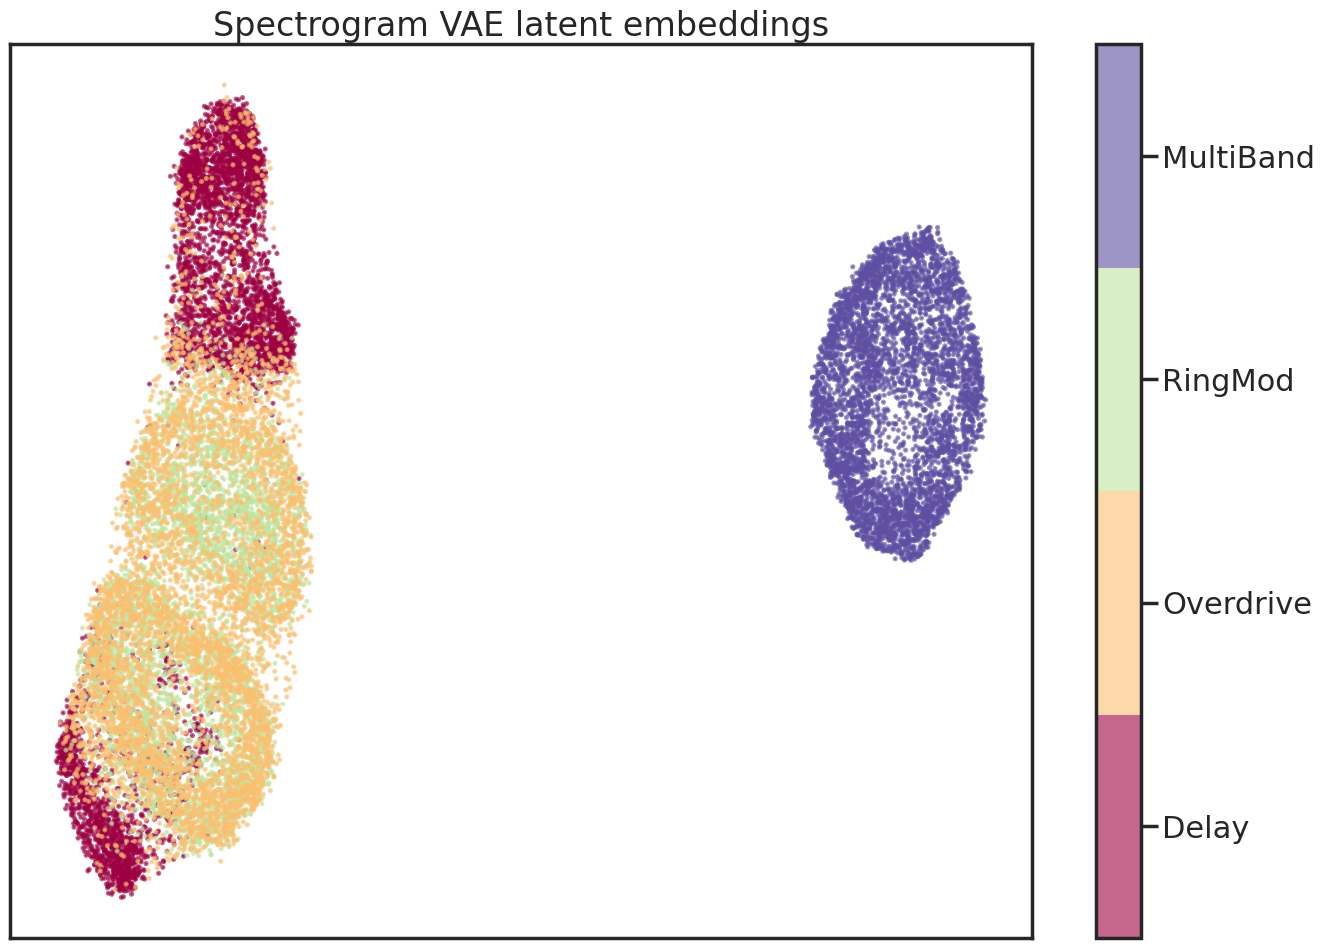

In [14]:
fig, ax = plt.subplots(1, figsize=(14, 10))

plt.scatter(*umap_data.T, s=3, c=plot_labels, cmap='Spectral', alpha=.6)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(num_fx+1)-0.5)
cbar.set_ticks(np.arange(num_fx))
cbar.set_ticklabels([fx_name.split()[-1] for fx_name in DAFX_TO_USE])
plt.title(f'Spectrogram VAE latent embeddings')
plt.tight_layout()
plt.savefig(f'./figures/latent_analysis/{CHECKPOINT_ID}_{num_fx}dafx.png')